In [128]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.integrate as integrate
import astropy.constants as c
import astropy.units as u
import scipy as sp
from astropy.modeling import models
from astropy.cosmology import Planck15 as cosmo

In [129]:
global meKeV; meKeV = 5.109989461e+02


# Radiative transfer integrals
# ------------------------------------------------------------------------
# Standard non-relativistic, thermal relative flux density SZ scaling factor
def gSZ(x):
    factor  = -4.+x*(np.exp(x)+1.)/(np.exp(x)-1.)
    factor *= (x**4.)*np.exp(x)/((np.exp(x)-1.)**2.0)
    return factor

# Generalised form of the relative flux density SZ scaling factor
def gSZtilde(xnu,Te=0.0,p1=1.,p2=1.e3,alpha=2.,etype='thermal'):
    if (Te==0.0):
        factor = gSZ(xnu)
    else:
        if (etype in ['thermal','Thermal']):
            factor  = integrate.dblquad(jszThermal,0.0,np.inf,lambda x: 0.0,lambda x: np.inf,args=(xnu,Te))[0]
            factor -= planckSpectrum(xnu)
            factor *= meKeV/Te
        elif (etype in ['powerlaw','power_law','powerLaw','PowerLaw']):
            factor  = integrate.dblquad(jszPowerLaw,0.0,np.inf,lambda x: 0.0,lambda x: np.inf,args=(xnu,p1,p2,alpha))[0]
            factor -= planckSpectrum(xnu)
            factor *= meKeV/Te
        elif (etype in ['ultrarelativistic','ultra-relativistic','ultrarel','ultraRel']):
            factor  = planckSpectrum(xnu)*meKeV/Te
    return factor

# Thermal electron momentum distribution
def jszThermal(p,t,x,Te):
    electronThermal = ((meKeV/Te)/sp.special.kn(2,(meKeV/Te)))*p*p*np.exp(-(meKeV/Te)*np.sqrt(1.+p*p))
    return redistrFunction(t,p)*planckSpectrum(x/t)*electronThermal

# Non-thermal electron momentum distribution (power-law)
def jszPowerLaw(p,t,x,p1,p2,alpha):
  # Ultra-relativisitc : p1=1, p2=1e3, alpha=2
  # Relativistic       : p1=3, p2=1e3, alpha=2
    electronPowerLaw = (alpha-1.)*(p**(-alpha))/((p1**(1.-alpha))-(p2**(1.-alpha)))
    factor = redistrFunction(t,p)*planckSpectrum(x/t)*electronPowerLaw

    return np.where((p1<p<p2),0.00,factor)

# Planck spectrum
def planckSpectrum(x):
    return (x**3.)/(np.exp(x)-1.)

# Photon redistribution function
def redistrFunction(t,p):
    if (np.abs(np.log(t))>2.*np.arcsinh(p)):
        factor = 0.0
    else:
            factor  = (3.+(3.+p*p)*p*p)/np.sqrt(1.+p*p)
            factor -= (2.*np.arcsinh(p)-np.abs(np.log(t)))*(1.5+p*p)/p
            factor *= 3.*(1.+t)/(8.*(p**5.))
            factor -= (1.+((10.+(8.+4.*p*p)*p*p)+t)*t)*3.*np.abs(1.-t)/(32.*t*(p**6.))
    return factor

def kT_cr(p1,p2,alpha):
    factor = integrate.quad(lambda p: f_cr(p, alpha, p1, p2)*1/3*p*p**2/np.sqrt(1+p**2)*meKeV, 0, np.inf)
    return factor[0]
    #

In [130]:
#In the below functions, t is the photon frequency shift factor and T is the temperature
#def K(t,p):
#    return -3*np.abs(1-t)/(32*p**6*t)*(1+(10+8*p**2 + 4*p**4)*t+t**2) + \
#(3*(1+t))/(8*p**5)*((3+3*p**2+p**4)/np.sqrt(1+p**2) - (3+2*p**2)/(2*p)*(2*np.arcsinh(p) -np.abs(np.log(t))))

def K(t,p):
    factor = -3*np.abs(1-t)/(32*p**6*t)*(1+(10+8*p**2 + 4*p**4)*t+t**2) + \
             (3*(1+t))/(8*p**5)*((3+3*p**2+p**4)/np.sqrt(1+p**2) - (3+2*p**2)/(2*p)*(2*np.arcsinh(p) -np.abs(np.log(t))))
    return np.where(np.abs(np.log(t))>2.*np.arcsinh(p),0.00,factor)

def K_s(s, p):
    es = np.exp(s)
    return(K(es, p)*es)

def K_int(t, f, **kwargs):
    return integrate.quad(lambda p: f(p, **kwargs)*K(t,p), 0, np.inf)[0]

def _K_1_s(s, f, **kwargs):
    return integrate.quad(lambda p: f(p, **kwargs)*K_s(s,p), 0, np.inf, limit = 100000)[0]

K_1_s = np.vectorize(_K_1_s, excluded = ['f'], otypes = [np.float])

def _f_cr(p, alpha, p1, p2):
    if p1 < p < p2:
        return (alpha -1)*p**(-1*alpha)/(p1**(1-alpha)-p2**(1-alpha))
    else:
        return 0
    
f_cr = np.vectorize(_f_cr, excluded=['alpha','p1', 'p2'], otypes = [np.float]) 

def f_th(p,T):
    #'T' should be in units of eV
    try:
        T = T.to(u.keV)
    except:
        print('Error: T cannot be converted to eV')
        return
    beta_th = (meKeV/T.value)
    return beta_th/sp.special.kn(2,beta_th)*p**2*np.exp(-1*beta_th*np.sqrt(1+p**2))

 
def planckSpectrum(x):
    return (x**3.)/(np.exp(x)-1.)    
    
#def j(x, f, **kwargs):
#    return integrate.quad(lambda t: i(x/t).value*K_int(t, f, **kwargs), 0, np.inf)

def j(x,f, **kwargs):
    return integrate.dblquad(lambda t, p: planckSpectrum(x/t)*f(p, **kwargs)*K(t,p), 0, np.inf, lambda p: 0, lambda p: np.inf)[0]

def _gTilde(x,f, **kwargs):
    return j(x,f,**kwargs) - planckSpectrum(x)

gTilde = np.vectorize(_gTilde, excluded = ['f'], otypes = [np.float])


# Replicating fig 2 in Enslin 2000

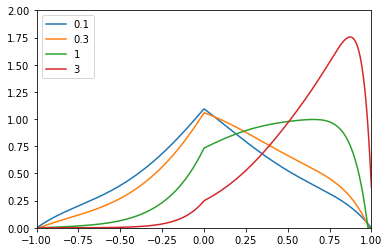

In [3]:
#This replicates the photon scattering probability function, called K(t,P) here and in zubair's paper and P in Enslin 2000
#The plot is of the log freq shift version but also validates K

s_space = np.linspace(-3.6,3.6,10000)
ps = [0.1, 0.3, 1, 3]
s_max_p = [0.2, 0.6, 1.8, 3.6]

for i, p in enumerate(ps):
    x = s_space/s_max_p[i]
    y = K_s(s_space, p)*s_max_p[i]
    plt.plot(x,y, label = str(p))
    
plt.xlim(-1,1)
plt.ylim(0, 2)
plt.legend()
plt.show()

# Replicating Fig 3 in Colafrancesco

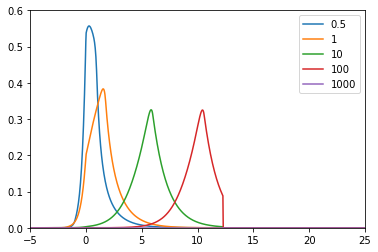

In [4]:
s_space = np.linspace(-5, 25,1000)
ps = [0.5, 1, 10, 100, 1000]

for i, p in enumerate(ps):
    x = s_space
    y = K_1_s(s_space, f_cr, alpha = 2.5, p1=p, p2 = 1e8)
    plt.plot(x,y, label = str(p))
    
plt.ylim(0, 0.6)
plt.xlim(-5,25)
plt.legend()
plt.show()

# Replicating Fig.4 is Esslin

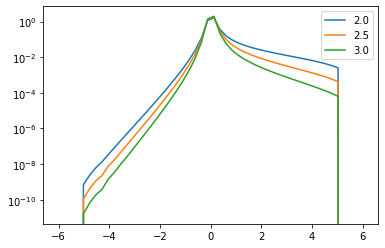

In [6]:
alphas = [2.0, 2.5, 3.0]
s_space = np.linspace(-6,6)
for i, alpha in enumerate(alphas):
    x = s_space
    y = K_1_s(s_space, f_cr, alpha = alpha, p1=0.1, p2 = 10)
    plt.plot(x,y, label = str(alpha))
    
#plt.xlim(-6,6)
#plt.ylim(-14, 0.5)
plt.yscale('log')
plt.legend()
plt.show()
    

# Electron momentum spectrum, non-thermal

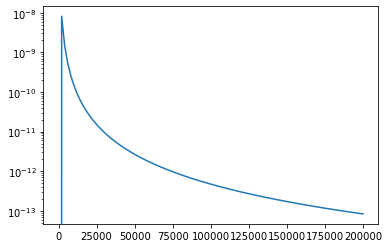

In [7]:
x = np.linspace(0,2e5, 100)
y = f_cr(x, alpha = 2.5, p1 = 1, p2 = 1e8)

plt.plot(x,y)
plt.yscale('log')
plt.show()


# Electron momentum spectrum, thermal

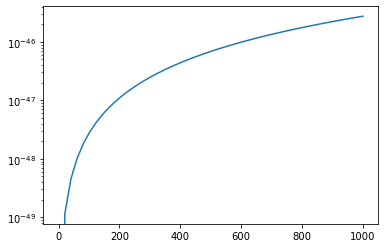

In [8]:
x = np.linspace(0,1e3)
y = f_th(x, 10000*u.eV)

plt.plot(x,y)
plt.yscale('log')
plt.show()

# Plankian dist

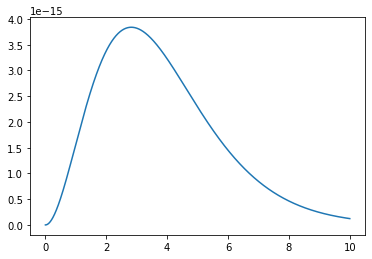

<Quantity 3.77351683e-15 erg / (cm2 Hz s sr)>

In [18]:
x = np.linspace(0.00001,10, 100000)
y =  planckSpectrum(x)

plt.plot(x,y)
plt.show()
planckSpectrum(2.5)

# gSZ thermal

<ipython-input-83-26ddbaf60006>:44: RuntimeWarning: overflow encountered in exp
  return (x**3.)/(np.exp(x)-1.)
/local/jupyter2021/lib/python3.8/site-packages/scipy/integrate/quadpack.py:880: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


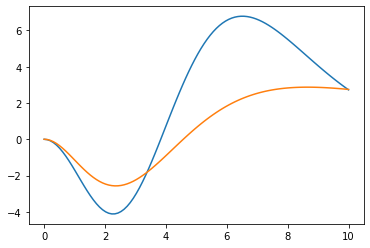

In [85]:
x = np.linspace(0.00001,10, 100)

y = gSZtilde(x,Te=0.0,p1=1.,p2=1.e3,alpha=2.,etype='thermal')
y2 = np.zeros(len(x))
for i, ix in enumerate(x):
    y2[i] = gSZtilde(ix,Te=100,p1=1.,p2=1.e3,alpha=2.,etype='thermal')

plt.plot(x,y, label = 'g')
plt.plot(x,y2, label = 'g_th')
plt.show()

In [72]:
y = gTilde(0.5, f = f_cr, alpha=2.5, p1=1, p2=10000)


<ipython-input-68-b88532225871>:43: RuntimeWarning: overflow encountered in exp
  return (x**3.)/(np.exp(x)-1.)


# f plot

In [131]:
x = 0.5284


Ts = np.logspace(0,3, 100)
ps = np.logspace(-1,2, 100)
f_th_arr = np.zeros(len(Ts))
f_cr_arr = np.zeros(len(Ts))
g = gSZtilde(x,Te=0.0,p1=1.,p2=1.e3,alpha=2.,etype='thermal')
for i, T in enumerate(Ts):
    kT_cr_temp = kT_cr(p1=ps[i], p2=1e5, alpha =2.5)
    f_th_arr[i] = gSZtilde(x,Te=T,p1=1.,p2=1.e3,alpha=2.,etype='thermal')/g
    f_cr_arr[i] = gSZtilde(x, Te = kT_cr_temp, p1 = ps[i], p2=1.e5,alpha=2.5, etype='powerlaw')/g
    



<ipython-input-129-6ea11d8f5ca3>:59: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  factor = integrate.quad(lambda p: f_cr(p, alpha, p1, p2)*1/3*p*p**2/np.sqrt(1+p**2)*meKeV, 0, np.inf)
/local/jupyter2021/lib/python3.8/site-packages/scipy/integrate/quadpack.py:880: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/local/jupyter2021/lib/python3.8/site-packages/scipy/integrate/quadpack.py:880: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad

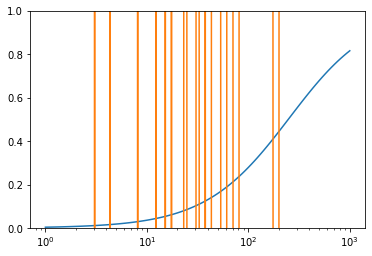

In [125]:
plt.plot(Ts, 1-f_th_arr, label = 'Thermal')
plt.plot(Ts, 1-f_cr_arr, label = 'Non-Thermal')

plt.plot
plt.xscale('log')
plt.ylim(0,1)
plt.show()

In [96]:
gSZtilde(0.5,Te=1.0,p1=1.,p2=1.e3,alpha=2.,etype='powerlaw')

<ipython-input-95-d2d0eb273c5d>:44: RuntimeWarning: overflow encountered in exp
  return (x**3.)/(np.exp(x)-1.)


17617.366114794426

In [126]:
f_cr_arr

array([128.85420144, 129.68890377, 130.25812799, 131.56269299,
       130.66588442, 133.15655697, 133.90284911, 133.99351234,
       135.20572902, 134.42918212, 135.7661387 , 136.73315384,
       134.91321137, 134.52748807, 134.88967227, 133.65517289,
        -0.38443385, 132.95847983, 131.91386355, 132.34754808,
       132.46594917,  -0.38752543, 127.32371088, 126.66277242,
       127.63331983, 123.66065382, 121.98841249, 120.7857373 ,
       117.35015299, 115.44886348,  -0.3903825 , 112.16235654,
       110.39395503, 108.93912575, 106.08553163, 103.58784098,
        -0.39136958,  99.41177711,  98.60123545,  -0.39174108,
        91.2351741 ,  -0.39195917,  81.37121876,  83.26013196,
        81.39094598,  -0.39237067,  -0.39246457,  71.6447883 ,
        72.02169282,  -0.3927559 ,  -0.39285335,  65.81824276,
        -0.3930509 ,  59.38046307,  -0.39325498,  -0.39335919,
        -0.39346827,  -0.39357439,  48.39378152,  -0.39379879,
        -0.39391612,  -0.39403812,  45.13534981,  -0.39